### Dependence on the computed growth rate on the number of runs tha the simulation was repeated

- The simulation for each set of parameters is repeated multiple times. 
- Perform the linear fit on the emittance values for each one of the runs.
- The mean of all the growth rates is computed and plotted in a bar plot along with the error bars which correspond to the standard deviation between the growth rates.
- A scan is performed over multiple runs to understand the dependance of the computed growth on the number of runs that the simulation was repeated.

In [1]:
import sys
sys.path.append('../utils/')
from my_functions import *
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### Plotting paramerters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### 1) Load the data
a) Give the paths to the data in /afs/.

b) Load the values of the transverse emittance in a dictionary.

In [32]:
n_runs = 9 # number of runs that the simulation was repeated
turns = 1e5
f_rev = 43375.86 # [Hz] The revolution frequency of the machine 
turns_list = np.arange(0,turns)
time = turns_list/f_rev # [s], type: list

In [33]:
path_to_data = '/afs/cern.ch/user/n/nattrian/private/tbt_sixtracklib_gpus/PNmytest_A1e-8_KlofKlod1_5e5turns/'
name_template = 'tbt_'
noise_type = 'PN' # 'PN', 'AN', 'BOTH'

In [34]:
# phase noise
ex_dict_pn = {} # type: dictionary
ey_dict_pn = {}
for run in range(n_runs):
    print(run)
    temp_name = '{}'.format(run) # the suffix of the name of the current study
    # A. load the turn by turn data in a dictionary
    temp_dict_pn = pickle.load( open( path_to_data+name_template+temp_name+'.pkl', "rb" ) )
    # B. Create a different list for each run and save the emittance values
    ex_dict_pn[temp_name] = temp_dict_pn['neps_x'] # PΝ
    ey_dict_pn[temp_name] = temp_dict_pn['neps_y']

0
1
2
3
4
5
6
7
8


#### 2A) Plot the emittance evolution for every run
In the command plot choose which one of the dictionaries:
- ex_dict_pn[temp_name] 
- ey_dict_pn[temp_name]

you want to study.

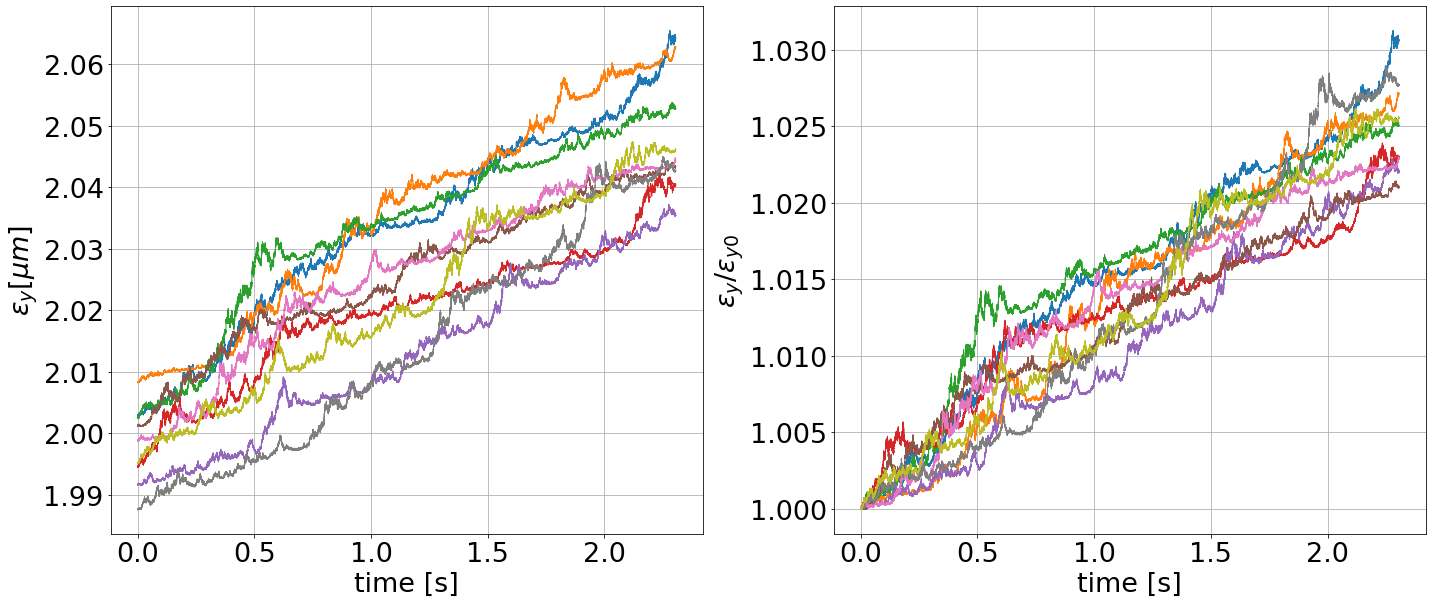

In [37]:
fig = plt.figure(figsize=(20, 8.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for run in range(n_runs):
    temp_name = '{}'.format(run) # the suffix of the name of the current study
    ax1.plot(time, np.array(ey_dict_pn[temp_name][:int(turns)])*1e6, c='C{}'.format(run))
    ax2.plot(time, np.array(ey_dict_pn[temp_name][:int(turns)])/ey_dict_pn[temp_name][:int(turns)][0], c='C{}'.format(run))

ax1.grid()
ax1.set_xlabel('time [s]')
ax1.set_ylabel(r'$\epsilon_y [\mu m]$')
ax2.grid()
ax2.set_xlabel('time [s]')
ax2.set_ylabel(r'$\epsilon_y / \epsilon_{y0} $')
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_270GeV_SPS_PN1e-8_VRF2_37MV_1e5Nb_{}turns_{}runs.png'.format(turns, n_runs))

#### 7) Calculate the emittance growth for each run rate via a linear fit
- Polynomial fit. The degree of the fitting polynomial is 1. 
- V plane only and phase noise only, if otherwise choose the apropriate dictionary from step 1.

    - ex_dict_pn[temp_name] 
    - ey_dict_pn[temp_name]


In [38]:
m_dict = []
b_dict = []
err_dict = []
for run in range(n_runs):
    temp_name = '{}'.format(run)
    # linear fit
    [m, b], cov = np.polyfit(time, ey_dict_pn[temp_name][:int(turns)], 1, cov=True)
    # compute the error of the gradient of the fit slope
    err= np.sqrt(np.diag(cov))
    m_dict.append(m)
    b_dict.append(b)
    err_dict.append(err)

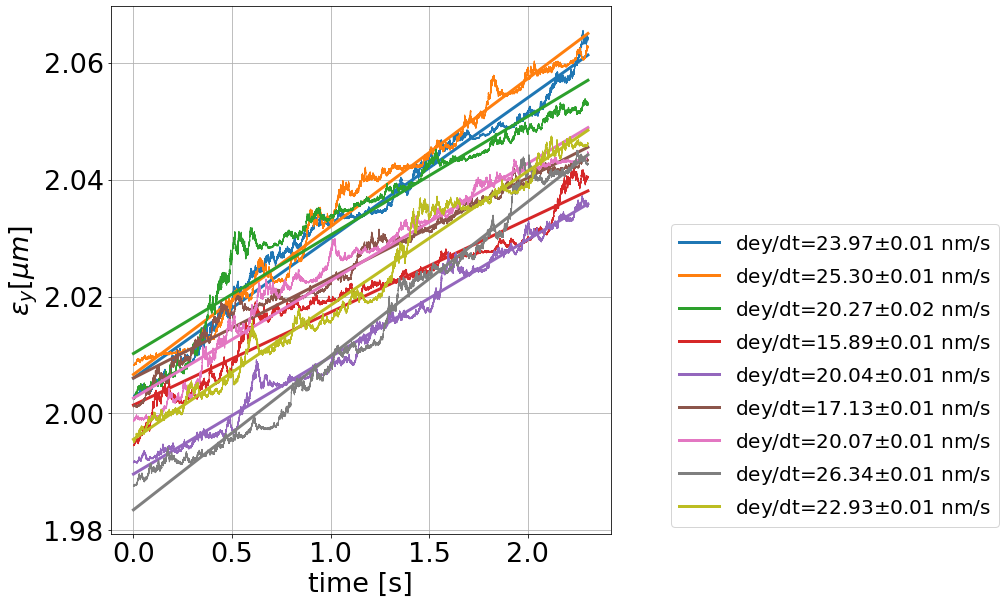

In [39]:
fig = plt.figure(figsize=(14.5, 8.5))
for run in range(n_runs):
    temp_name = '{}'.format(run)
    plt.plot(time, np.array(ey_dict_pn[temp_name][:int(turns)])*1e6, c='C{}'.format(run))
    plt.plot(time, (m_dict[run]*time+b_dict[run])*1e6, c = 'C{}'.format(run), label='dey/dt={0:.2f}'.format(m_dict[run]*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_dict[run][0]*1e9), linewidth = 3)
    
    plt.xlabel('time [s]')
    plt.ylabel(r'$\epsilon_y [\mu m]$')
    #plt.legend(loc=0)
    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.3))
plt.grid()    
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_{}turns_{}runs.png'.format(turns, n_runs))

#### 8) Compute the mean value and the std of the above growth rates iterating over different number of runs

In [40]:
dey_list = []
std_list = []

for run in range(2, n_runs+1):
    dey_list.append(np.mean(m_dict[:run]))
    std_list.append(np.std(m_dict[:run]))

In [44]:
dey_list[-2]

2.1127070888270876e-08

<BarContainer object of 8 artists>

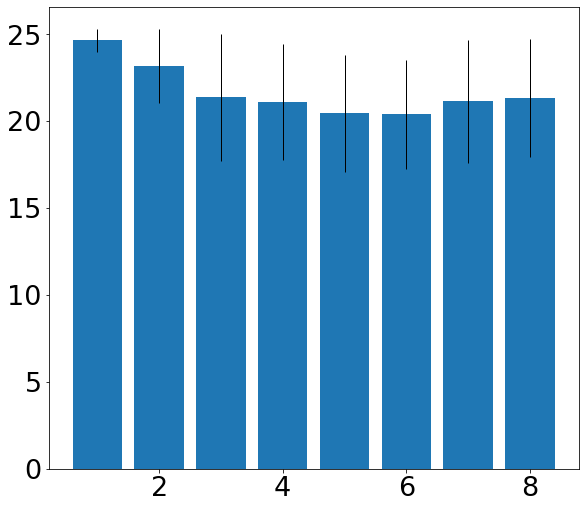

In [41]:
plt.bar(np.arange(n_runs)[1:], np.array(dey_list)*1e9, yerr=np.array(std_list)*1e9)

### 9) Compute the theoretically expected rate
- Define the machine and beam parameters
- Define the levels of noise for A
- Compute the expected rate from the functions in '../utils/my_functions.py'
- Define the colors according to the type of the study

In [43]:
# Machine parameters
betay = 73 # 73 m at CC2, 76 m at CC1
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
beta_0 = 0.999999
gamma_0 = 287.7
sigma_z = 0.155 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
#PSD_phi = 1.4e-10
PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
print(PSD_phi, PSD_A)

1.6777905638665135e-10 0.0


In [44]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.5168486015622045, CDeltaA = 0.24157569921889774
expected growth = 23.582259735020834 nm/s


#### 8) Compute the mean and the standard deviation of these slopes were computed over all turns.

In [45]:
growth_rate = np.mean(m_dict)
standard_deviation = np.std(m_dict)
print(standard_deviation/np.sqrt(n_runs))
errors = 0
for run in range(n_runs):
    errors = errors+ err_dict[run][0]**2    
growth_rate_error = np.sqrt(errors)/n_runs
print(growth_rate_error*1e9)
print(growth_rate*1e9)
print(standard_deviation)

2.8064887513098933e-10
0.0016602633720496655
24.623882456111495
4.860981108139271e-10


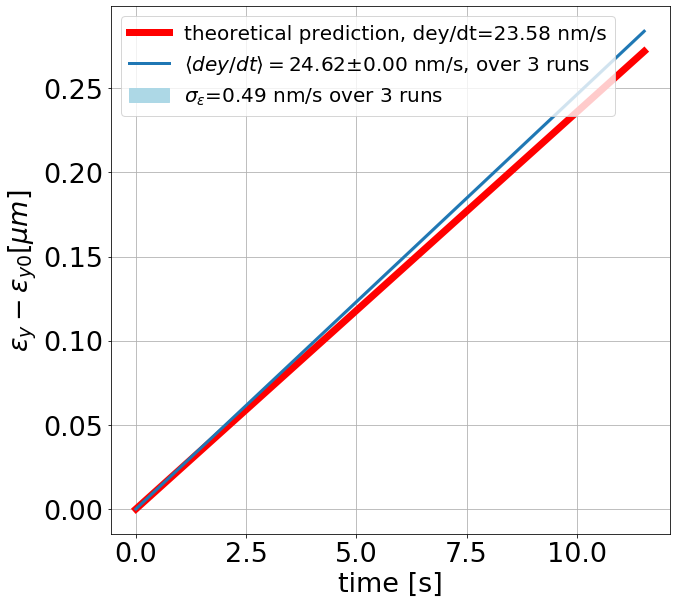

In [46]:
# expected slope from analytical calculations
plt.plot(time, (expected_growth*time)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={:.2f} nm/s'.format(expected_growth*1e9))
# emittance values obtained from the simulation averaged over runs
plt.plot(time, growth_rate*time*1e6, c=my_color, linewidth=3, label=r'$\langle dey/dt  \rangle={0:.2f}$'.format(growth_rate*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(growth_rate_error*1e9)+', over {} runs'.format(n_runs))

plt.fill_between(time, growth_rate*time*1e6 - standard_deviation*1e6, growth_rate*time*1e6 + standard_deviation*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon}$'+'={:.2f} nm/s'.format(standard_deviation*1e9)+ ' over {} runs'.format(n_runs))

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} [\mu m]$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(0, 0.08)
#plt.ylim(0, 0.6)

plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emit_growth_rate_substract_initial_emittance_270GeV_SPS_{}_PN1e-8_VRF2_37MV_1e5Nb_5e5turns_mean{}run_fill_between_method2.png'.format(noise_type, n_runs))

In [19]:
print('The emittance growth rate is computed: {}'.format(growth_rate*1e9)+'+-'+'{} nm/s'.format(standard_deviation*1e9))

The emittance growth rate is computed: 23.138081866236902+-1.8639857584091055 nm/s


In [47]:
print('The emittance growth rate is computed: {}'.format(growth_rate*1e9)+'+-'+'{} nm/s'.format(standard_deviation*1e9))

The emittance growth rate is computed: 24.623882456111495+-0.48609811081392706 nm/s
